# Example 1 

In [1]:
# pyAPEP package import
import pyadserver.isofit as isofit
import pyadserver.simide as simide

# Data treatment package import
import numpy as np
import pandas as pd
import copy

# Data visualization package import
import matplotlib.pyplot as plt

In [2]:
# Data import
# adsorbent 1
Data_zeo13 = pd.read_csv('Example1_Zeolite13X.csv')
# adsorbent 2
Data_ac = pd.read_csv('Example1_Activated_carbon.csv')
# adsorbent 3
Data_zeo5 = pd.read_csv('Example1_Zeolite5A.csv')

Data = [Data_zeo13, Data_ac, Data_zeo5]

In [13]:
# Find best isotherm function, Ideal PSA simulation
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
iso_pure = []
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    N2_iso, _, _, _ = isofit.best_isomodel(P_N2, q_N2)
    H2_iso, _, _, _ = isofit.best_isomodel(P_H2, q_H2)

    iso_pure.append([N2_iso, H2_iso])

In [18]:
iso_mix_list = []
for i in range(3):
    N2_iso_ = lambda P,T: iso_pure[i][0](P)
    H2_iso_ = lambda P,T: iso_pure[i][1](P)
    
    iso_mix = lambda P,T : isofit.IAST([N2_iso_, H2_iso_], P, T)
    
    iso_mix_app = copy.deepcopy(iso_mix)
    iso_mix_list.append(iso_mix_app)

In [20]:
results = []
for i in range(3):
    iso_mix = iso_mix_list[i]
    
    CI1 = simide.IdealColumn(2, iso_mix )

    # Feed condition setting
    P_feed = 8      # Feed presure (bar)
    T_feed = 293.15    # Feed temperature (K)
    y_feed = [1/4, 3/4] # Feed mole fraction (mol/mol)
    CI1.feedcond(P_feed, T_feed, y_feed)

    # Operating condition setting
    P_high = 8 # High pressure (bar)
    P_low  = 1 # Low pressure (bar)
    CI1.opercond(P_high, P_low)

    # Simulation run
    x_tail = CI1.runideal()
    R = 1- (y_feed[0]*(1-x_tail[0]))/(x_tail[0]*(1-y_feed[0]))
    print(R*100)       # Output: [x_H2, x_N2]
    results.append(R*100)

91.00367830050382
83.41420765092575
88.39914789168635


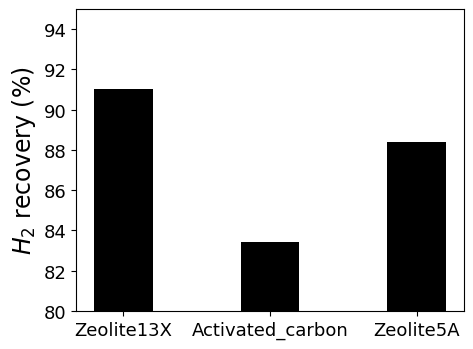

In [21]:
# Results plot
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
plt.figure(dpi=100, figsize=(5, 4))
plt.bar(Adsorbent, results, width=0.4, color='black')
plt.ylim([80, 95])
plt.ylabel('$H_2$ recovery (%)', fontsize=17)
plt.yticks(fontsize=13)
plt.xticks( fontsize=13)
plt.show()

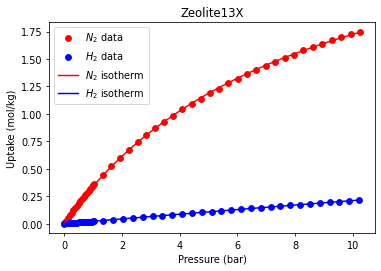

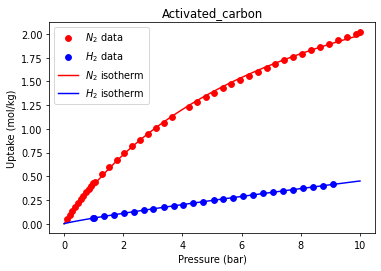

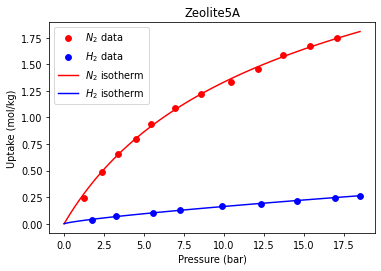

In [23]:
# Visualization ==> SI?
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    plt.figure(dpi=70)
    plt.scatter(P_N2, q_N2, color = 'r')
    plt.scatter(P_H2, q_H2, color = 'b')
    
    P_max= max(max(P_N2), max(P_H2))
    P_dom = np.linspace(0, P_max, 100)
    plt.plot(P_dom, iso_pure[i][0](P_dom), color='r' )
    plt.plot(P_dom, iso_pure[i][1](P_dom), color='b' )
    
    plt.xlabel('Pressure (bar)')
    plt.ylabel('Uptake (mol/kg)')
    plt.title(f'{Adsorbent[i]}')
    plt.legend(['$N_2$ data', '$H_2$ data',
                '$N_2$ isotherm','$H_2$ isotherm'], loc='best')
    
    plt.show()

# Example 2

In [1]:
# pyAPEP package import
import pyadserver.isofit as isofit
import pyadserver.simsep as simsep

# Data treatment package import
import numpy as np
import pandas as pd

# Data visualization package import
import matplotlib.pyplot as plt

In [2]:
# Data import
Data = pd.read_csv('Example2_Zeolite13X.csv')

In [3]:
P_CO2 = Data['Pressure_CO2 (bar)'].dropna().values
q_CO2 = Data['Uptake_CO2 (mol/kg)'].dropna().values

P_CH4 = Data['Pressure_CH4 (bar)'].dropna().values
q_CH4 = Data['Uptake_CH4 (mol/kg)'].dropna().values

CO2_iso, _, _, _ = isofit.best_isomodel(P_CO2, q_CO2)
CH4_iso, _, _, _ = isofit.best_isomodel(P_CH4, q_CH4)
CO2_iso_ = lambda P,T: CO2_iso(P)
CH4_iso_ = lambda P,T: CH4_iso(P)



In [4]:
# IAST ==> simulation 에 적합한 형태로 변형
iso_mix = lambda P,T : isofit.IAST([CO2_iso_,CH4_iso_], P, T)

def mix_iso_arr(P_list, T_list):
    q1_re = []
    q2_re = []
    for i in range(len(P_list[0])):
        P = [P_list[0][i]] + [P_list[1][i]]
        q = iso_mix(P, T_list[i])
        q1, q2 = q[0], q[1]
        q1_re.append(q1)
        q2_re.append(q2)

    q1_arr = np.array(q1_re)
    q2_arr = np.array(q2_re)    
    return [q1_arr, q2_arr]

In [5]:
# Define column
N = 21
L = 1.35
A_cros = np.pi*0.15**2
CR1 = simsep.column(L, A_cros, n_component=2, N_node = N)

In [12]:
### Sorbent prop
voidfrac = 0.37      # (m^3/m^3)
D_particle = 12e-4   # (m)
rho = 1324           # (kg/m^3)
CR1.adsorbent_info(mix_iso_arr, voidfrac, D_particle, rho)

### Gas prop
Mmol = [0.044, 0.016] # kg/mol
mu_visco= [16.13E-6, 11.86E-6]   # (Pa sec) 
CR1.gas_prop_info(Mmol, mu_visco)
# https://www.engineeringtoolbox.com/methane-dynamic-kinematic-viscosity-temperature-pressure-d_2068.html?vA=313&degree=K#
# https://www.engineeringtoolbox.com/carbon-dioxide-dynamic-kinematic-viscosity-temperature-pressure-d_2074.html

### Transfer prop
k_MTC  = [1E-4, 1E-4]     # m/sec==============> 값필요

a_surf = 1 #Volumatric specific surface area (m2/m3)==============> 값필요 
D_disp = [1E-6, 1E-6]     # m^2/sec ==============> 값필요 
CR1.mass_trans_info(k_MTC, a_surf, D_disp)

dH_ads = [31.164e3,20.856e3]   # J/mol
Cp_s = 900
Cp_g = [38.236, 35.8]  # J/mol/K
# https://www.engineeringtoolbox.com/carbon-dioxide-d_974.html
# https://www.engineeringtoolbox.com/methane-d_1420.html

h_heat = 100            # J/m2/K/s==============> 값필요 
CR1.thermal_info(dH_ads, Cp_s, Cp_g, h_heat)

In [13]:
### Operating conditions
P_inlet = 9
P_outlet = 8.0
T_feed = 323
y_feed = [0.33,0.67]

Cv_inlet = 0.02E-1             # inlet valve constant (m/sec/bar)
Cv_outlet= 2.0E-1           # outlet valve constant (m/sec/bar)

Q_feed = 0.05*A_cros  # volumetric flowrate (m^3/sec)

CR1.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed,
                   Cv_inlet, Cv_outlet,
                   Q_inlet = Q_feed,
                   assigned_v_option = True)

In [14]:
### Initial conditions
P_init = 8.5*np.ones(N)    # (bar)
y_init = [0.001*np.ones(N), 0.999*np.ones(N)] # (mol/mol)
T_init = T_feed*np.ones(N)
q_init = mix_iso_arr(P_init*np.array(y_init), T_init)

CR1.initialC_info(P_init, T_init, T_init, y_init, q_init)
print(CR1)

[[Current information included here]] 
Design          : True
adsorbent_info  : True
gas_prop_info   : True
mass_trans_info : True
thermal_info    : True
boundaryC_info  : True
initialC_info   : True
Flow direction  : Foward
Assigned velocity option: True



In [15]:
# CR1.change_init_node(21)
# Number of node = 51
y_res, z_res, t_res = CR1.run_mamoen(25,n_sec = 20, 
                                    CPUtime_print = True)

# y,z, t = CR1.run_mamoen(2000, n_sec=10, CPUtime_print=True)   #mamoen : mass, momentum, energy / n_sec : 1초를 몇개로 쪼갤래?

Simulation of this step is completed.
This took    74.326 mins to run. 



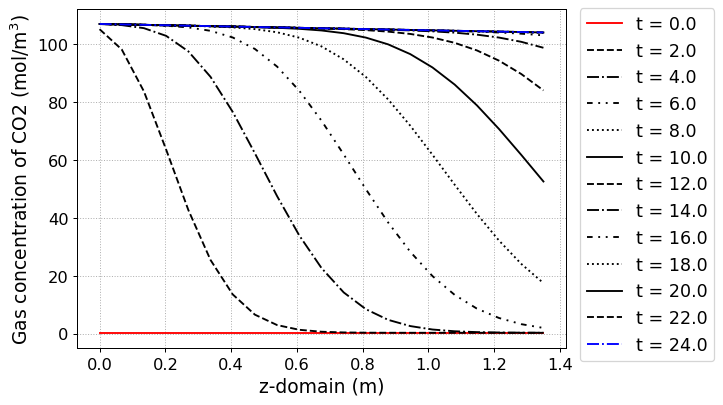

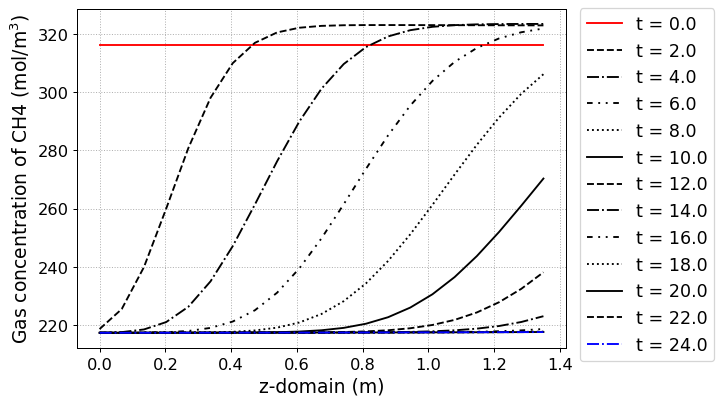

In [16]:
fig = CR1.Graph(2, 0, loc=[1.15,0.9], 
               yaxis_label = 'Gas concentration of CO2 (mol/m$^3$)',
               file_name = 'CO2_gas_conc.png')
fig = CR1.Graph(2, 1, loc=[1.15,0.9], 
               yaxis_label = 'Gas concentration of CH4 (mol/m$^3$)',
               file_name = 'CH4_gas_conc.png')

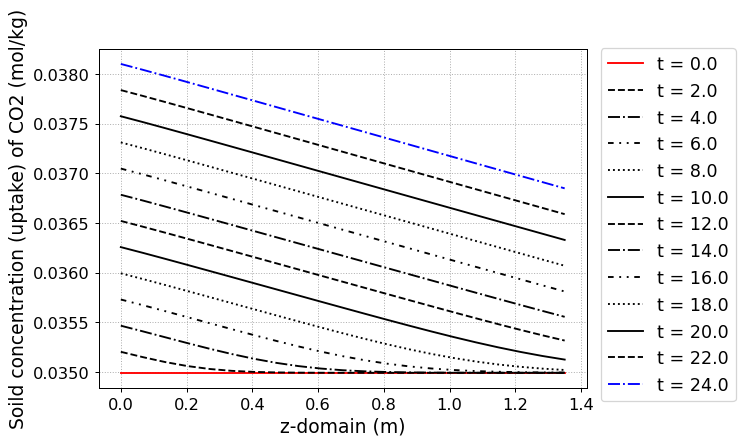

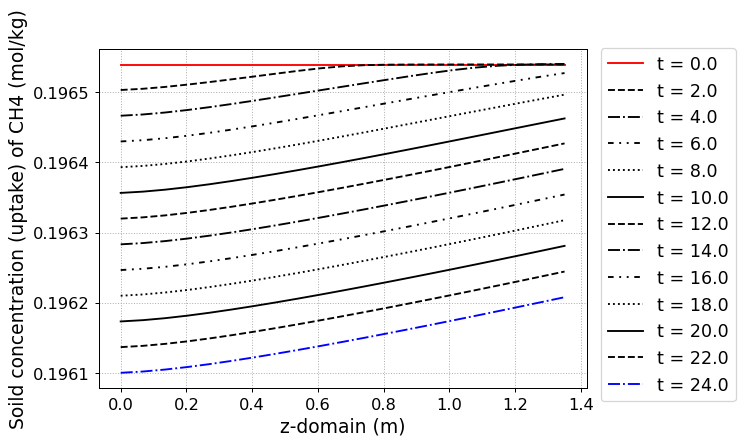

In [17]:
fig = CR1.Graph(2, 2, loc=[1.15,0.9], 
               yaxis_label = 'Soild concentration (uptake) of CO2 (mol/kg)',
               file_name = 'CO2_uptake.png')
fig = CR1.Graph(2, 3, loc=[1.15,0.9], 
               yaxis_label = 'Soild concentration (uptake) of CH4 (mol/kg)',
               file_name = 'CH4_uptake.png')

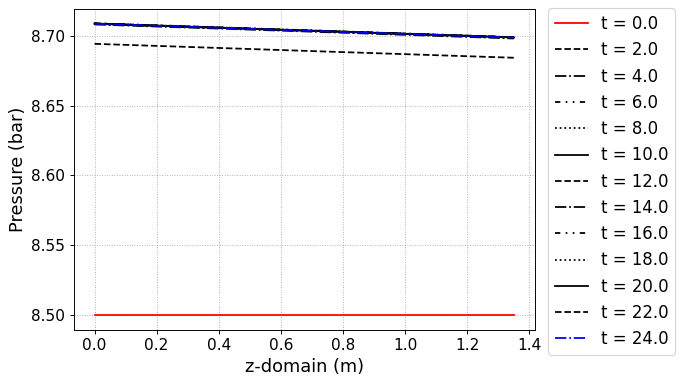

In [18]:
fig, ax = CR1.Graph_P(2, loc=[1.15,0.9])

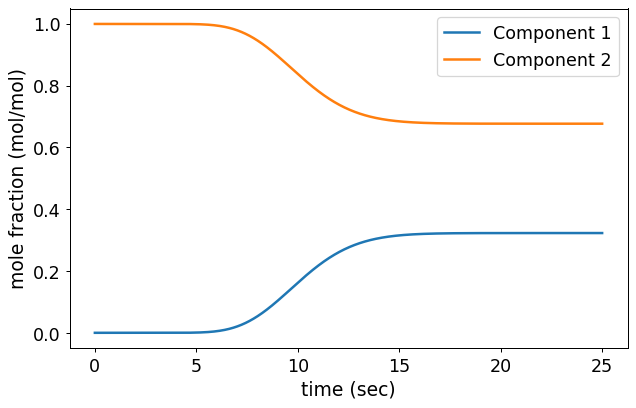

In [19]:
bt = CR1.breakthrough(True)

In [56]:
t_pred = 25.0
print('At t = {0:2.1f} sec'.format(t_pred))
print('Comp 1 = ', bt[0](t_pred))
print('Comp 2 = ', bt[1](t_pred))

At t = 25.0 sec
Comp 1 =  0.6691897414784652
Comp 2 =  0.3308102585215348
